## Introduction
This notebook introduces the **Normalised Burn Ratio** (NBR), a key index used in satellite remote sensing to assess burn severity.<br>

Unlike optical visualisations like **True Colour Images** and **False Colour Images**, the **NBR** provides a quantitative measure of the land's condition. It **highlights** the drastic **difference** in how healthy vegetation and burnt areas reflect light in specific wavelengths.
Following the [past tutorial]() and applying new assets (the b12 band) from the **Sentinel-2 L2A** Collection available through the [EOPF STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en) in the efficient `.zarr` format, we will calculate the NBR **before** and **after** a fire event.<br>
By subtracting these two values, we will compute the **delta NBR** (dNBR). This powerful metric allows us to precisely map the fire's severity and gain a deeper understanding of its impact on the landscape.


###  What we will learn

- 🛰️ Access and mask the **SWIR** and **NIR** bands from Sentinel-2 mission
- 🔎 Explore how to process and georeference the values inside a `.zarr` asset
- 🔥 Complement **pre** and **post** fire analysis with **quantitative analysis**

<hr>

In [17]:
from distributed import LocalCluster
from pystac_client import Client
import numpy as np
import xarray as xr
import dask.array as da 
import time
import matplotlib.pyplot as plt
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import box 

##### `validate_scl()`

This function creates a boolean mask to identify valid pixels in a Sentinel-2 Scene Classification (SCL) dataset by excluding invalid land cover types.

Recieves:

- `scl` : An xarray.DataArray representing the Scene Classification (SCL) band from a Sentinel-2 image.


In [18]:
def validate_scl(scl):
# A list of SCL values to be considered invalid (e.g., NO_DATA, SATURATED, CLOUD, WATER)
    invalid = [0, 1, 3, 6, 7, 8, 9, 10]
# Return a boolean mask where True indicates a valid pixel (i.e., not in the invalid list)
    return ~scl.isin(invalid)

##### `normalisation_str_gm()`

Applies percentile-based contrast stretching and gamma correction to a band.

Recieves:

- `band_array` : the extracted `xarray` for the selected band
- `p_min` : percentile min value
- `p_max`: percentile max value
- `gamma_val`: gamma correction

In [19]:
def normalisation_str_gm(band_array, p_min, p_max, gamma_val):

    # Calculate min and max values based on percentiles for stretching
    min_val = np.percentile(band_array[band_array > 0], p_min) if np.any(band_array > 0) else 0
    max_val = np.percentile(band_array[band_array > 0], p_max) if np.any(band_array > 0) else 1

    # Avoid division by zero if min_val equals max_val
    if max_val == min_val:
        stretched_band = np.zeros_like(band_array, dtype=np.float32)
    else:
        # Linear stretch to 0-1 range
        stretched_band = (band_array - min_val) / (max_val - min_val)

    # Clip values to ensure they are within [0, 1] after stretching
    stretched_band[stretched_band < 0] = 0
    stretched_band[stretched_band > 1] = 1

    # Apply gamma correction
    gamma_corrected_band = np.power(stretched_band, 1.0 / gamma_val)

    # Returns the corrected array:
    return gamma_corrected_band


##### `mask_sub_utm()`
This function masks a `.zarr` asset by subsetting it to a specified rectangular area defined by row and column indices.

Recieves:

- `zarr_asset` : The input Zarr array asset.
- `rows` : A list or array of row indices defining the vertical extent.
- `cols` : A list or array of column indices defining the horizontal extent.

In [20]:
def mask_sub_utm(zarr_asset, rows, cols):
# Calculates the minimum and maximum row and column indices
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()
# It then subsets the zarr_asset using these indices
    masked_asset = zarr_asset.isel(
    y=slice(row_min, row_max + 1), x=slice(col_min, col_max + 1)
)
    return masked_asset

##### `zarr_mask_utm()`
This function creates a boolean mask to identify the rows and columns within a Zarr dataset that fall within a specified bounding box, assuming UTM coordinates.

Recieves:
- `bounding_box` : A tuple or list containing (min_longitude, min_latitude, max_longitude, max_latitude).
- `zarr` : The input Zarr dataset, expected to have 'x' and 'y' dimensions corresponding to longitude and latitude/UTM coordinates.

In [21]:
def zarr_mask_utm ( bounding_box, zarr):
# Unpack the bounding box coordinates for clarity
    min_lon, min_lat, max_lon, max_lat = bounding_box
# Create boolean masks for longitude and latitude dimensions based on the bounding box
    lon_mask = (zarr['x'] >= min_lon) & (zarr['x'] <= max_lon)
    lat_mask = (zarr['y'] >= min_lat) & (zarr['y'] <= max_lat)
# Combine the individual masks to create a single bounding box mask
    bbox_mask = lon_mask & lat_mask
# Find the row and column indices where the combined mask is True
    cols , rows = np.where(bbox_mask)

    return rows, cols

##### `lat_lon_to_utm_box()`

Converts the latitude and longitude coordinates of a bounding box from a geographic system to the UTM (Universal Transverse Mercator) coordinate system.

Recieves:

- `bot_left` : A tuple or list containing the longitude and latitude of the bottom-left corner.
- `top_right` : A tuple or list containing the longitude and latitude of the top-right corner.

In [22]:
def lat_lon_to_utm_box(bot_left,top_right):
    # Longitude and latitude of the bottom-left corner
    west_utm, south_utm = transformer.transform(bot_left[0],bot_left[1])
    # Longitude and latitude of the top-right corner
    east_utm, north_utm = transformer.transform(top_right[0],top_right[1])

    # A new list with the converted UTM coordinates
    return [ west_utm, south_utm , east_utm , north_utm ]

Just as [tutorial](), we start by setting up a parallel computing environment to efficiently handle large datasets.<br>
This creates a virtual cluster on your machine, consisting of a scheduler that manages tasks and multiple workers that process them.

In [23]:
cluster = LocalCluster()
client = cluster.get_client()
client

/opt/anaconda3/envs/eopf_wf_clone/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50785 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50785/status,
Dashboard: http://127.0.0.1:50785/status,Workers: 5
Total threads: 10,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50786,Workers: 0
Dashboard: http://127.0.0.1:50785/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:50799,Total threads: 2
Dashboard: http://127.0.0.1:50800/status,Memory: 4.80 GiB
Nanny: tcp://127.0.0.1:50789,


Following the workflow from [tutorial](), we need to define the specific **spatial** and **temporal** parameters for our analysis. We will set the same area of interest over the Province of Nuoro Sardinia, Italy. We define the dates for our pre-fire and post-fire period.<br>

According to [EFFIS's definition](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-severity#:~:text=The%20proposed%20methodology%20is%20recommended,and%20post%2Dfire%20NBR%20composites.), the **severity** for each fire is calculated after **30 days of the date of the fire**, and it can be classified as it follows:

| Class | dNBR range (multiplied by 1000) |
|:---|:---|
| Unburned or Regrowth | < 100 |
| Low severity | 100 - 270 |
| Moderate low severity | 270 - 440 |
| Moderate high severity | 440 - 660 |
| High severity | >= 660 |

For the pre-fire state, we will use an image from **3rd of June 2025**, and due data processing and data avilability, the closest available image for post fire state is set to **3rd July 2025**. Additional information such as CRS and the interest bands **Near Infra Red** (NIR) and **Short Wave Infrared** (SWIR) are set.

In [ ]:
# Dates of interest
# Before the fire:
pre_f  = '2025-06-03'
# After the fire:
post_f = '2025-07-03'

# The area of interest for our filtering
bbox = (8.847198,40.193395,
        8.938865,40.241895)

# Definition of the transformer parameters for reprojection and correct overlay of layers
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32632", always_xy=True)
t_utm_to_deg = Transformer.from_crs("EPSG:32632","EPSG:4326", always_xy=True)

# The false colour channels we are interested to retrieve coposite:
swir = 'b12'
nir =  'b8a'

# Defining a larger bounding box for better visualisation:
bbox_vis = (8.649555,40.073583,
          9.127893,40.343840)

# A fixed geographic bounding box to highlight the AOI in the map format
map_box = bbox
# A new list with the converted UTM coordinates
bbox_utm = lat_lon_to_utm_box((bbox_vis[0], bbox_vis[1]),(bbox_vis[2], bbox_vis[3]))

def_collection = 'sentinel-2-l2a' #collection

# we are interested in the performance the code will have
st = time.time()

### Connection to the Catalog
Now we can use our defined parameters to connect to the data catalog. We will query the catalog to retrieve all available **Sentinel-2** imagery that corresponds to our specific defined query arguments.

In [26]:
eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/" #root starting point
eopf_catalog = Client.open(url=eopf_stac_api_root_endpoint) # calls the selected url
eopf_catalog

<Client id=eopf-sample-service-stac-api>

## Pre - Fire

From the items retrieved, we will select the earliest available image. This image will serve as our baseline for the pre-fire conditions, providing a clean snapshot of the landscape before the event.<br>
We extract the `r20m` group under measurements group, as this is the resolution we will be focusing in.

In [27]:
# We define the search over the whole day, from 12:00 am to 11:59 pm
date_pre = pre_f + 'T00:00:00Z/' + pre_f + 'T23:59:59.999999Z' # interest period

s2_pre = list(eopf_catalog.search(
                bbox= bbox, 
                datetime= date_pre,
                collections=def_collection).item_collection())

av_urls = [item.assets["product"].href for item in s2_pre]

# Open the last Zarr item from the list of URLs as a data tree.
pre_zarr = xr.open_datatree(
    av_urls[-1], engine="zarr",
    chunks={},
    )

# Select the 20m reflectance measurements from the data tree.
zarr_meas_pre = pre_zarr.measurements.reflectance.r20m

# Extractthe cloud free mask at 20m resolution:
l2a_class_20m_pre = pre_zarr.conditions.mask.l2a_classification.r20m.scl
valid_mask_pre = validate_scl(l2a_class_20m_pre)  # Boolean mask

/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2900/2635104523.py:12: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  pre_zarr = xr.open_datatree(
/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2900/2635104523.py:12: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, w

To calculate the **Normalised Burn Ratio** (NBR), we will access the specific spectral bands we need: the **Near-Infrared** (NIR) band (B8A) and the **Shortwave Infrared** (SWIR) band (B12).

Once we access them, we need to ensure our data is focused on our area of interest (AOI). We will apply the same **masking** and **clipping** functions used in our [previous tutorial]() to remove invalid pixels (NA, water and low clouds), and trim the imagery to our precise `bbox_utm`, making it ready for calculation.

In [28]:
# Create UTM masks for rows and columns based on the bounding box.
rows_pre, cols_pre= zarr_mask_utm (bbox_utm, zarr_meas_pre)

# Extract and slice the y-dimension values from the Zarr measurement.
y_zarr = zarr_meas_pre['y'].isel(y=slice(rows_pre.min(), rows_pre.max() + 1)).values
# Extract and slice the x-dimension values from the Zarr measurement.
x_zarr = zarr_meas_pre['x'].isel(x=slice(cols_pre.min(), cols_pre.max() + 1)).values

# Select the red, green, and blue bands and apply the valid mask.
swir_pre = zarr_meas_pre[swir].where(valid_mask_pre)
nir_pre =  zarr_meas_pre[nir].where(valid_mask_pre)

# Mask and clip the selected bands using the row and column indices.
swir_pre = mask_sub_utm(swir_pre,rows_pre, cols_pre).values
nir_pre = mask_sub_utm(nir_pre,rows_pre, cols_pre).values

Once we obtain the masked assets, we can visualise them before calculating the **NBR**.

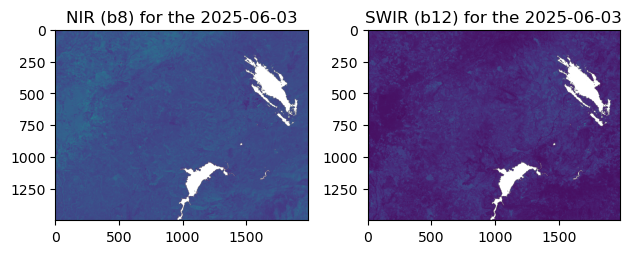

In [29]:
# Create a figure to plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(nir_pre)
axs[0].set_title(f'NIR (b8) for the {pre_f}')
# Plot the filtered land surface temperature data on the second subplot
axs[1].imshow(swir_pre)
axs[1].set_title(f'SWIR (b12) for the {pre_f}') # Add a title for clarity
# Adjust the layout
fig.tight_layout()
# Display the plot
plt.show()

With our `swir_pre` and `nir_pre` bands ready, we can now calculate the first part of our ratio.<br>
We will apply the NBR formula:

$$\frac{(NIR - SWIR)} {(NIR + SWIR)}$$

An important consideration for this process is the possibility of division by zero when calculating the composite. To prevent this, we create a mask for the denominator layer. The mask assigns a value of `1` to any pixel that is `0` in the original denominator, while keeping the original values for all other pixels.<br>
This simple but crucial step ensures the calculation can be completed without errors.

In [30]:
# We calculate the nbr for our pre fire event
pre_difference = nir_pre - swir_pre

# to deal with 0 divisions on the NBR formula

pre_addition = nir_pre + swir_pre

# we create a mask to detect possible 0 values
zero_mask = (pre_addition == 0)
pre_z= pre_addition.copy()

pre_z = da.where(pre_addition == 0, 1, pre_z)


# Calculatig our NBR for the moment before the fire:

nbr_pre  = da.where(pre_addition == 0, 0, pre_difference / pre_z)

and, once we have defined the operation, we obtain the following composite:

/opt/anaconda3/envs/eopf_wf_clone/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 48.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 1.0, 'NBR from the 2025-06-03')

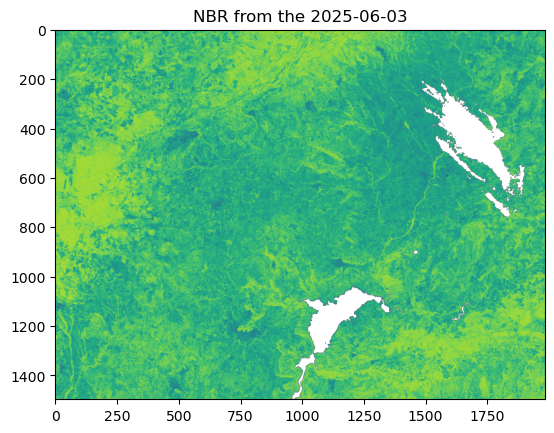

In [31]:
# Visualising the clipped red band:
plt.imshow(nbr_pre, vmin=-1.0, vmax=1.0)
plt.title(f'NBR from the {pre_f}')

## Post Fire

The next step is, creating the composite for the second part of the equation... the **post-fire** visualisation.<br>

We repeat the process for our post-fire data. We retrieve again the first available Sentinel-2 item from the catalog that corresponds to our post-fire date, followed by the extraction of the interest resolution group.

In [32]:
# We define the search over the whole day, from 12:00 am to 11:59 pm
date_post = post_f + 'T00:00:00Z/' + post_f + 'T23:59:59.999999Z' # interest period

s2_post = list(eopf_catalog.search(
                bbox= bbox, 
                datetime= date_post,
                collections=def_collection).item_collection())

av_urls = [item.assets["product"].href for item in s2_post]

post_zarr = xr.open_datatree(
    av_urls[-1], engine="zarr", #we always get the earliest one (last)
    chunks={},
    )

zarr_meas_post = post_zarr.measurements.reflectance.r20m

# Extractthe cloud free mask at 20m resolution:
l2a_class_20m_post = post_zarr.conditions.mask.l2a_classification.r20m.scl
valid_mask_post = validate_scl(l2a_class_20m_post)  # Boolean mask

/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2900/757934750.py:11: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  post_zarr = xr.open_datatree(
/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_2900/757934750.py:11: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, wh

We will apply the same **masking** and **clipping** functions to this new dataset to ensure it is clean and limited to our area of interest, making it ready for calculation, as it is based on a complete different scene.

In [ ]:
# Create UTM masks for rows and columns based on the bounding box.
rows_post, cols_post= zarr_mask_utm(bbox_utm, zarr_meas_post)

# Slice the y-dimension values using the new row indices.
y_zarr = zarr_meas_post['y'].isel(y=slice(rows_post.min(), rows_post.max() + 1)).values
# Slice the x-dimension values using the new column indices.
x_zarr = zarr_meas_post['x'].isel(x=slice(cols_post.min(), cols_post.max() + 1)).values

# define our zarr extracted coordinates
map_ext_deg = list(t_utm_to_deg.transform(np.nanmin(x_zarr),np.nanmin(y_zarr)) + 
                   t_utm_to_deg.transform(np.nanmax(x_zarr),np.nanmax(y_zarr)))

# Select the red, green, and blue bands and apply the valid mask.
swir_post = zarr_meas_post[swir].where(valid_mask_post)
nir_post =  zarr_meas_post[nir].where(valid_mask_post)

# Mask and clip the selected bands using the row and column indices.
swir_post = mask_sub_utm(swir_post,rows_post, cols_post).values
nir_post = mask_sub_utm(nir_post,rows_post, cols_post).values


After our masking, we obtain the following bands

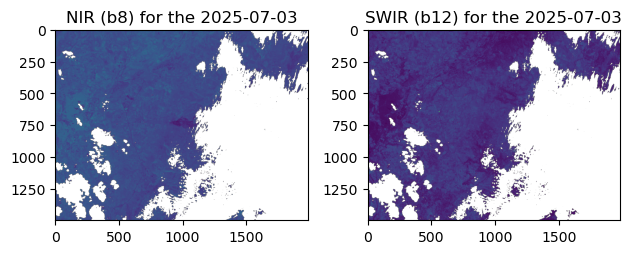

In [34]:
# Create a figure to plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(nir_post_cl)
axs[0].set_title(f'NIR (b8) for the {post_f}')
# Plot the filtered land surface temperature data on the second subplot
axs[1].imshow(swir_post_cl)
axs[1].set_title(f'SWIR (b12) for the {post_f}') # Add a title for clarity
# Adjust the layout
fig.tight_layout()
# Display the plot
plt.show()

With our post-fire bands, we will calculate the second part of our ratio. We apply the **0** division consideration masking and the **NBR** formula again to these bands to get the post-fire **NBR** value.

/opt/anaconda3/envs/eopf_wf_clone/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 48.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0.5, 1.0, 'NBR from the 2025-07-03')

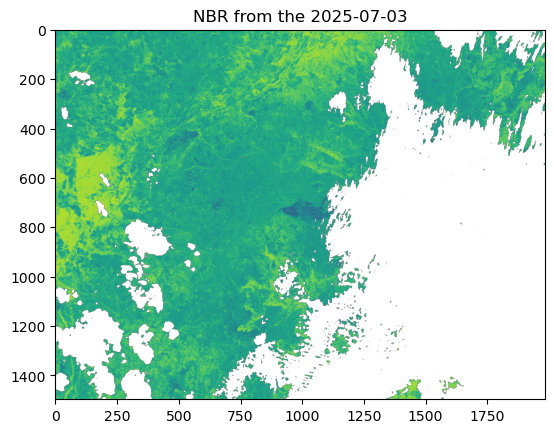

In [ ]:
# We calculate the nbr for our post fire event
post_difference = nir_post - swir_post

# to deal with 0 divisions on the NBR formula
post_addition = nir_post + swir_post

# we create a mask to detect possible 0 values
zero_mask = (post_addition == 0)
post_z= post_addition.copy()

post_z = da.where(post_addition == 0, 1, post_z)

nbr_post  = da.where(post_addition == 0, 0, post_difference / post_z)

# Visualising the clipped red band:
plt.imshow(nbr_post, vmin=-1.0, vmax=1.0)
plt.title(f'NBR from the {post_f}')


## Differenced NBR

The last calculation step for our analysis is the **delta NBR** (dNBR). This index is calculated by **subtracting** the **post-fire** NBR **from** the **pre-fire** NBR. Higher dNBR values indicate more severe damage, providing a quantitative measure of the fire's impact.

$$dNBR = prefireNBR - postfireNBR$$

In [ ]:
# Calculate the delta Normalised Burn Ratio (dNBR) by subtracting the post-fire NBR from the pre-fire NBR.
dNBR = (nbr_pre - nbr_post) * 1000

# bringing the dNBR to memory
dNBR_c = dNBR.compute()

/opt/anaconda3/envs/eopf_wf_clone/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 93.38 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


As our calculation was based on dask array for a faster computation, we bring it back to memory and multiply it by 1000 to be able to compare it to **Key & Benson (2006) severity thresholds**, proposed by [EFFIS](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-severity#:~:text=The%20proposed%20methodology%20is%20recommended,and%20post%2Dfire%20NBR%20composites.)

Text(0.5, 1.0, 'Calculated dNBR')

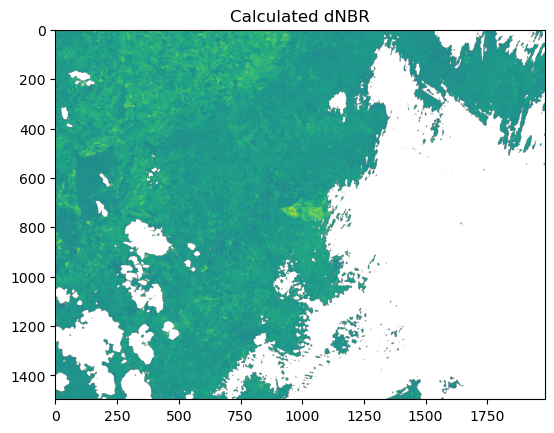

In [37]:
# Visualising the clipped red band:
# plt.imshow(dNBR)
plt.imshow(dNBR, vmin=-1000.0, vmax=1000.0)
plt.title(f'Calculated dNBR')

In [38]:
et = time.time()

total_t = et - st

print('Total Running Time: ', total_t,' seconds')

Total Running Time:  17.75494885444641  seconds


Finally, we will plot our results to visualise the **burn severity**.<br>
Using the `cartopy` library, we can create a georeferenced map that accurately displays our data based on its CRS and geospatial bounding box.<br>
The **dNBR** data will be presented on this map using a colour scheme that clearly highlights the most affected areas, giving us a final, comprehensive overview of the wildfire's impact.

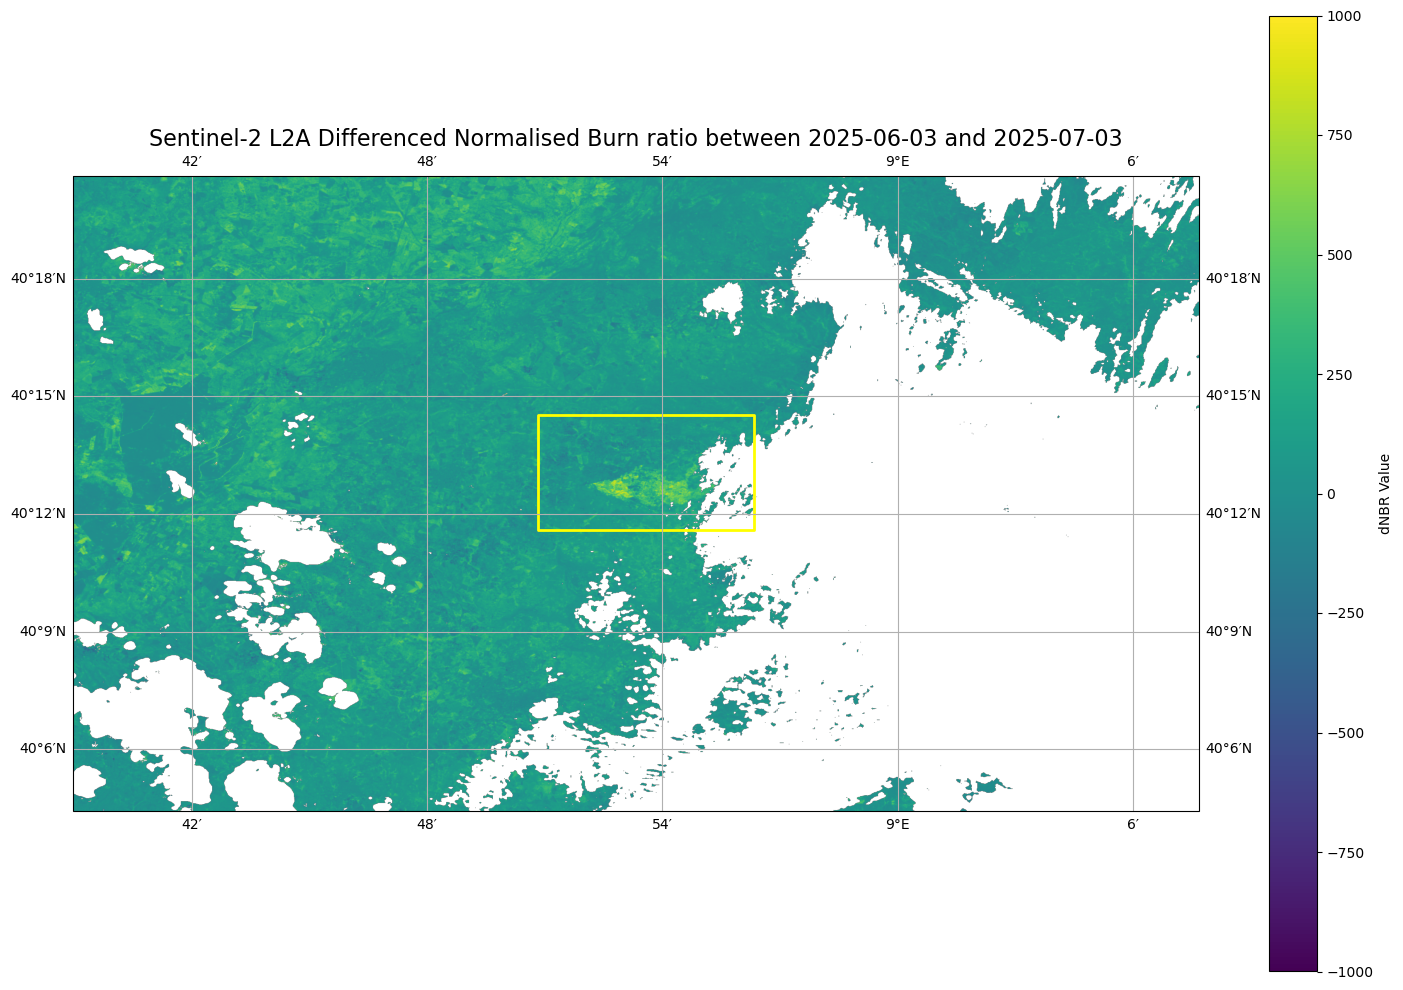

In [39]:
# Creating the Geometry
map_box = box(map_box[0],map_box[1],map_box[2],map_box[3])

#Overlay
plt.figure(figsize=(15, 10))
# Create a figure with a specified size.
data_ll = ccrs.PlateCarree()
# Set up the plot with a UTM projection.
ax = plt.axes(projection=data_ll)

# Display the Differenced Normalised Burn Ratio (dNBR)
im = ax.imshow(dNBR_c, origin='upper',
                extent=(bbox_vis[0],bbox_vis[2],
                        bbox_vis[1],bbox_vis[3]),  # item
                         vmin=-1000.0, vmax=1000.0,
                transform=data_ll)

# features
plt.colorbar(im, ax=ax, label='dNBR Value')
ax.add_geometries([map_box], crs=data_ll, facecolor='none', edgecolor='yellow', linewidth=2, linestyle='-')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False) # Add gridlines and labels


# Set the title of the plot.
plt.title(f'Sentinel-2 L2A Differenced Normalised Burn ratio between {pre_f} and {post_f}', fontsize=16)
# Adjust plot to ensure all elements fit without overlapping.
plt.tight_layout()
# Show the final plot.
plt.show()

As the plot shows, the burn scar provides a spectral response through **dNBR**, even after the asset was clipped to remove thin cirrus clouds and water bodies.<br>
The **severity** values are **over 750**, which classifies this as being in the high-severity range of Key & Benson (2006).

| Class | dNBR range (multiplied by 1000) |
|:---|:---|
| Unburned or Regrowth | < 100 |
| Low severity | 100 - 270 |
| Moderate low severity | 270 - 440 |
| Moderate high severity | 440 - 660 |
| High severity | >= 660 |


Besides the asset's accessibility, it is important to note the time efficiency of this monitoring workflow. The entire process, from defining the area of interest to searching, accessing, processing, and visualising the data takes **less** than **30 seconds**.<br>

This highlights the power of a streamlined approach using the `.zarr` format and the integration of **Dask's parallel computing**. There is no need to download any of the assets, as they are available directly in the cloud.

<hr>

## Conclusion

Having processed .....<br>

The generation of these composites, allow us to have a [...] <br> 
This enables us to replicate defined steps at various points in time. This overview, will allow us to understand the dynamics of a event cycle over time.

<hr>

## What’s next?

This online resource is under active development. So stay tuned for regular updates.